## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Tuple
import pickle as pkl

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import jax
import numpy as np
from jax import numpy as jnp
from jax.random import PRNGKey
from optax import adam, adamw
import pandas
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# disable jax JIT
#jax.config.update("jax_disable_jit", True)

import sys
import os

sys.path.append(os.path.abspath(".."))

from scripts.vigamlss import Normal, Gamma, CustomGEV,DataPreperator, DegenerateNormal, FullCovarianceNormal, MeanFieldNormal, HalfCauchy, CustomGPD
from scripts.vigamlss.utils.transformations import TransformationFunctions

2025-02-05 19:27:43.703748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738780063.720533  176841 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738780063.725612  176841 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Directories for Pickles

In [2]:
gev_fits_dir = sys.path[-1] + "/data/gev_fits"
gpd_fits_dir = sys.path[-1] + "/data/gpd_fits"
gamma_fits_dir = sys.path[-1] + "/data/gamma_fits"

## Custom Color Palettes

In [3]:
regression_palette = ["#4CAF50", "#2196F3", "#424242"]
line_colors = ["#57a7a8", "#506eaf", "#b04fa4"]
pred_line_colors = ["#00FFED", "#0055FF", "#FF00A5"]
loss_color = "#2C3E50"

## Plots

In [4]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_elbo(
    num_iterations,
    elbo_values,
    loss_color,
    percentage,
    save_path=None,
    file_name=None,
    window=None,
):
    """
    Plots the ELBO over iterations along with two zoomed-in plots for the first and last percentage of iterations.
    If a moving average is used, the main plot title will include the window size.
    """
    sns.set_theme(style="whitegrid")

    # Optionally smooth the ELBO values using a rolling window
    if window is not None and window > 1:
        elbo_values_smoothed = (
            pd.Series(elbo_values).rolling(window=window, min_periods=1).mean().values
        )
        y_values = elbo_values_smoothed
    else:
        y_values = elbo_values

    # Create a figure with GridSpec: the top row (row 0) will be the main plot;
    # the bottom row (row 1) is split into two columns for the zoomed-in plots.
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[2, 1])

    # Main ELBO plot (all iterations) – spans both columns in the first row
    ax_main = fig.add_subplot(gs[0, :])
    sns.lineplot(x=range(num_iterations), y=y_values, ax=ax_main, color=loss_color)

    # Build the main title and add window info if a moving average is used.
    main_title = "ELBO over Iterations"
    if window is not None and window > 1:
        main_title += f" with a MA-Window of {window}"
    ax_main.set_title(main_title, fontsize=15)

    ax_main.set_xlabel("Iteration", fontsize=13)
    ax_main.set_ylabel("ELBO", fontsize=13)

    # Compute the number of iterations corresponding to the given percentage.
    # Ensure at least one iteration is plotted.
    num_first = max(1, int(num_iterations * percentage))
    num_last = max(1, int(num_iterations * percentage))
    start_last = num_iterations - num_last

    # First additional plot: first percentage of iterations
    ax_first = fig.add_subplot(gs[1, 0])
    sns.lineplot(
        x=range(num_first), y=y_values[:num_first], ax=ax_first, color=loss_color
    )
    ax_first.set_title(f"First {percentage*100:.0f}% of Iterations", fontsize=13)
    ax_first.set_xlabel("Iteration", fontsize=12)
    ax_first.set_ylabel("ELBO", fontsize=12)

    # Second additional plot: last percentage of iterations
    ax_last = fig.add_subplot(gs[1, 1])
    sns.lineplot(
        x=range(start_last, num_iterations),
        y=y_values[start_last:],
        ax=ax_last,
        color=loss_color,
    )
    ax_last.set_title(f"Last {percentage*100:.0f}% of Iterations", fontsize=13)
    ax_last.set_xlabel("Iteration", fontsize=12)
    ax_last.set_ylabel("ELBO", fontsize=12)

    plt.tight_layout()

    # Optionally save the figure if a file name is provided
    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        if window is not None and window > 1:
            base += f"_window_{window}"
        file_name_svg = base + ".svg"
        full_file_path = (
            os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        )
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")

    plt.show()


def plot_regression_with_interval(
    scatter_x,
    scatter_y,  # Data for the scatter plot
    line_x,
    regression_y,  # Data for the regression line
    lower_hdi_bound,
    upper_hdi_bound,  # Data for the HDI
    hdi_alpha,
    palette,  # List of three colors: [scatter, regression, interval]
    scatter_label,
    regression_label,
    interval_label,
    xlabel,
    ylabel,
    title,
    fig_size=(12, 7),
    save_path=None,
    file_name=None,
):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=fig_size)

    sns.scatterplot(
        x=scatter_x,
        y=scatter_y,
        color=palette[0],
        label=scatter_label,
        alpha=0.7,
        ax=ax,
    )

    sns.lineplot(
        x=line_x,
        y=regression_y,
        color=palette[1],
        label=regression_label,
        linewidth=2.2,
        ax=ax,
    )

    ax.fill_between(
        line_x,
        lower_hdi_bound,
        upper_hdi_bound,
        color=palette[2],
        alpha=hdi_alpha,
        label=interval_label,
    )

    sns.lineplot(x=line_x, y=lower_hdi_bound, color=palette[2], ax=ax, alpha=hdi_alpha)
    sns.lineplot(x=line_x, y=upper_hdi_bound, color=palette[2], ax=ax, alpha=hdi_alpha)

    ax.legend(fontsize=10, loc="upper left")
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=14, fontweight="bold")

    plt.tight_layout()

    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        file_name_svg = base + ".svg"
        full_file_path = (
            os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        )
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")

    plt.show()


def plot_gev_gpd_syn_data(
    X,
    Y,
    regression_palette,
    line_palette,
    line1,
    line2,
    line3,
    scatter_xlabel,
    scatter_ylabel,
    scatter_title,
    line_xlabel,
    line_title,
    line1_label,
    line2_label,
    line3_label,
    file_name,
    save_path=None,
):
    sns.set_theme(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.scatterplot(x=X, y=Y, alpha=0.8, s=15, color=regression_palette[0], ax=axs[0])
    axs[0].set_xlabel(scatter_xlabel)
    axs[0].set_ylabel(scatter_ylabel)
    axs[0].set_title(scatter_title)
    xs_sorted = jnp.sort(X)
    y_line1 = line1(xs_sorted)
    y_line2 = line2(xs_sorted)
    y_line3 = line3(xs_sorted)
    sns.lineplot(
        x=xs_sorted,
        y=y_line1,
        label=line1_label,
        color=line_palette[0],
        linewidth=1.5,
        ax=axs[1],
    )
    sns.lineplot(
        x=xs_sorted,
        y=y_line2,
        label=line2_label,
        color=line_palette[1],
        linewidth=1.5,
        ax=axs[1],
    )
    sns.lineplot(
        x=xs_sorted,
        y=y_line3,
        label=line3_label,
        color=line_palette[2],
        linewidth=1.5,
        ax=axs[1],
    )
    axs[1].set_xlabel(line_xlabel)
    axs[1].set_title(line_title)
    axs[1].legend()
    plt.tight_layout()
    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        file_name_svg = base + ".svg"
        full_file_path = (
            os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        )
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")
    plt.show()


def plot_loc_scale_shape_comparison(
    X,
    line_loc,
    line_scale,
    line_shape,
    line_loc_pred,
    line_scale_pred,
    line_shape_pred,
    non_pred_palette,
    pred_palette,
    title,
    xlabel,
    ylabel,
    fig_size=(10, 6),
    save_path=None,
    file_name=None,
):
    """
    Plots a comparison of three line parameters and their predicted counterparts on one plot.
    """
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=fig_size)

    xs_sorted = jnp.sort(X)
    y_loc = line_loc(xs_sorted)
    y_scale = line_scale(xs_sorted)
    y_shape = line_shape(xs_sorted)

    # Plot the original (non-predicted) lines as dotted lines.
    ax.plot(xs_sorted, y_loc, linestyle="--", color=non_pred_palette[0], label="Location")
    ax.plot(xs_sorted, y_scale, linestyle="--", color=non_pred_palette[1], label="Scale")
    ax.plot(xs_sorted, y_shape, linestyle="--", color=non_pred_palette[2], label="Shape")

    # Plot the predicted lines as solid lines.
    ax.plot(
        xs_sorted,
        line_loc_pred,
        linestyle="-",
        color=pred_palette[0],
        label="Predicted Location",
    )
    ax.plot(
        xs_sorted,
        line_scale_pred,
        linestyle="-",
        color=pred_palette[1],
        label="Predicted Scale",
    )
    ax.plot(
        xs_sorted,
        line_shape_pred,
        linestyle="-",
        color=pred_palette[2],
        label="Predicted Shape",
    )

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.legend(fontsize=10, loc="best")
    plt.tight_layout()

    if file_name is not None:
        base, _ = os.path.splitext(file_name)
        file_name_svg = base + ".svg"
        full_file_path = (
            os.path.join(save_path, file_name_svg) if save_path else file_name_svg
        )
        plt.savefig(full_file_path, bbox_inches="tight", format="svg")
        print(f"Plot saved to {full_file_path}")

    plt.show()

## VIGAMLSS with Gamma Response

In [5]:
dbbmi_df = pandas.read_csv("../data/dbbmi_data.csv")
Y_dbbmi_np = dbbmi_df["bmi"].values
Y_dbbmi_jnp = jnp.array(Y_dbbmi_np)
X_dbbmi_np = dbbmi_df["age"].values
X_dbbmi_jnp = jnp.array(X_dbbmi_np)
X_dbbmi_DesignMatrix = DataPreperator(
    "DesignMatrix",
    X_dbbmi_jnp,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=20,
)()
K = X_dbbmi_DesignMatrix.K

dbbmi_λ_loc = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
dbbmi_γ_loc = DegenerateNormal("gammas_loc", K, dbbmi_λ_loc)
dbbmi_β0_loc = Normal("beta_0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
dbbmi_λ_scale = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
dbbmi_γ_scale = DegenerateNormal("gammas_scale", K, dbbmi_λ_scale)
dbbmi_β0_scale = Normal("beta_0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
Y_dbbmi = Gamma(
    "y",
    dbbmi_β0_loc + X_dbbmi_DesignMatrix @ dbbmi_γ_loc,
    dbbmi_β0_scale + X_dbbmi_DesignMatrix @ dbbmi_γ_scale,
    responses=Y_dbbmi_jnp,
)

results_dbbmi = Y_dbbmi.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=2000,
    mb_size=512,
    lr=0.01,
    max_norm=1.0,
    clip_min_max_enabled=False,
    zero_nans_enabled=False,
    prng_key=PRNGKey(0),
    scheduler_type="constant",
)

with open(gamma_fits_dir + "/results_dbbmi.pkl", "wb") as f:
    pkl.dump(results_dbbmi, f)

plot_elbo(
    results_dbbmi["svi_metadata"]["num_iterations"],
    results_dbbmi["losses"],
    loss_color,
    0.1,
    gamma_fits_dir,
    "loss_gamma",
    window=50,
)

KeyboardInterrupt: 

/tmp/ipykernel_96537/1892010145.py:19: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gamma_fits/regression_plot.svg


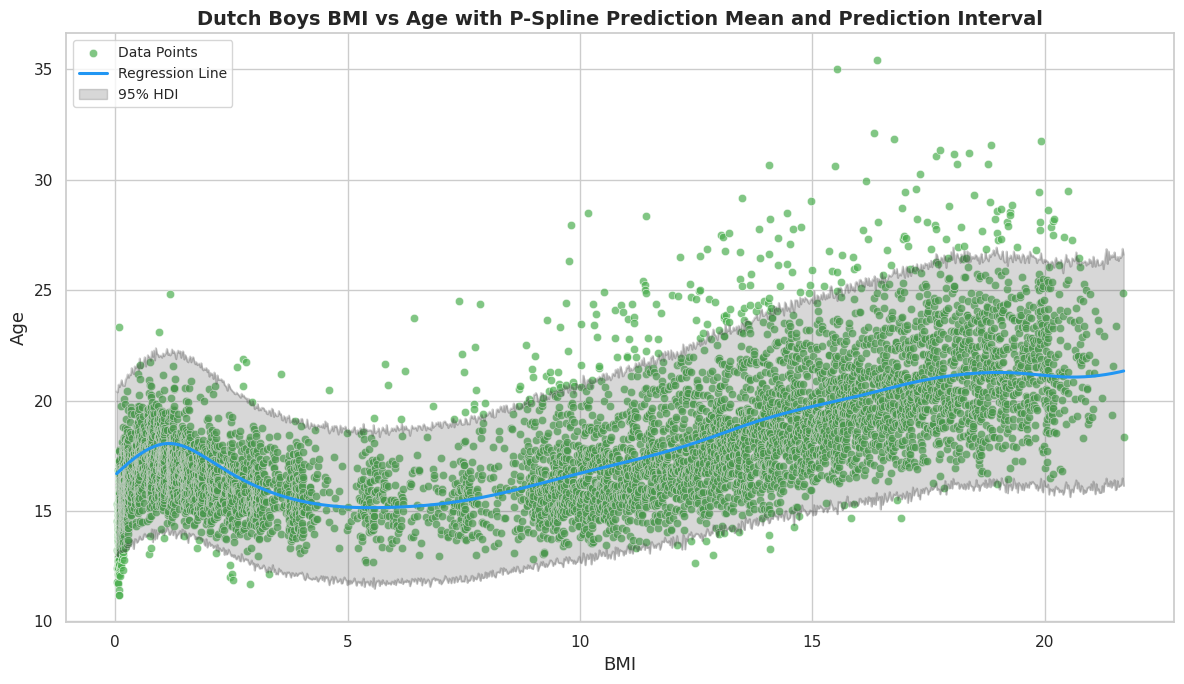

In [ ]:
β0_loc = results_dbbmi["transformed_loc_vi_parameters"]["beta_0_loc"]
γ_loc = results_dbbmi["transformed_loc_vi_parameters"]["gammas_loc"]
β0_scale = results_dbbmi["transformed_loc_vi_parameters"]["beta_0_scale"]
γ_scale = results_dbbmi["transformed_loc_vi_parameters"]["gammas_scale"]

X_min, X_max = X_dbbmi_jnp.min(), X_dbbmi_jnp.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign", X_line, "pspline", intercept=False, standardize=False, degree=3, num_knots=20
)()
linear_predictor_concentration = TransformationFunctions.softplus(β0_loc + X_line_design.matrix @ γ_loc)
linear_predictor_rate = TransformationFunctions.softplus(β0_scale + X_line_design.matrix @ γ_scale)

GAMMAs = tfd.Gamma(linear_predictor_concentration, linear_predictor_rate)

samples = GAMMAs.sample((5000,),PRNGKey(0))
mean_line = GAMMAs.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    scatter_x=X_dbbmi_np,
    scatter_y=Y_dbbmi_np,
    line_x=X_line,
    regression_y=mean_line,
    lower_hdi_bound=hdi_lower,
    upper_hdi_bound=hdi_upper,
    hdi_alpha=0.21,
    palette=regression_palette,
    scatter_label='Data Points',
    regression_label='Regression Line',
    interval_label='95% HDI',
    xlabel='BMI',
    ylabel='Age',
    title='Dutch Boys BMI vs Age with P-Spline Prediction Mean and Prediction Interval',
    save_path=gamma_fits_dir, 
    file_name="regression_plot.svg"
)

## VIGAMLSS with GEV Response

### Synthetic Data Creation

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/gev_syn_data_plot.svg


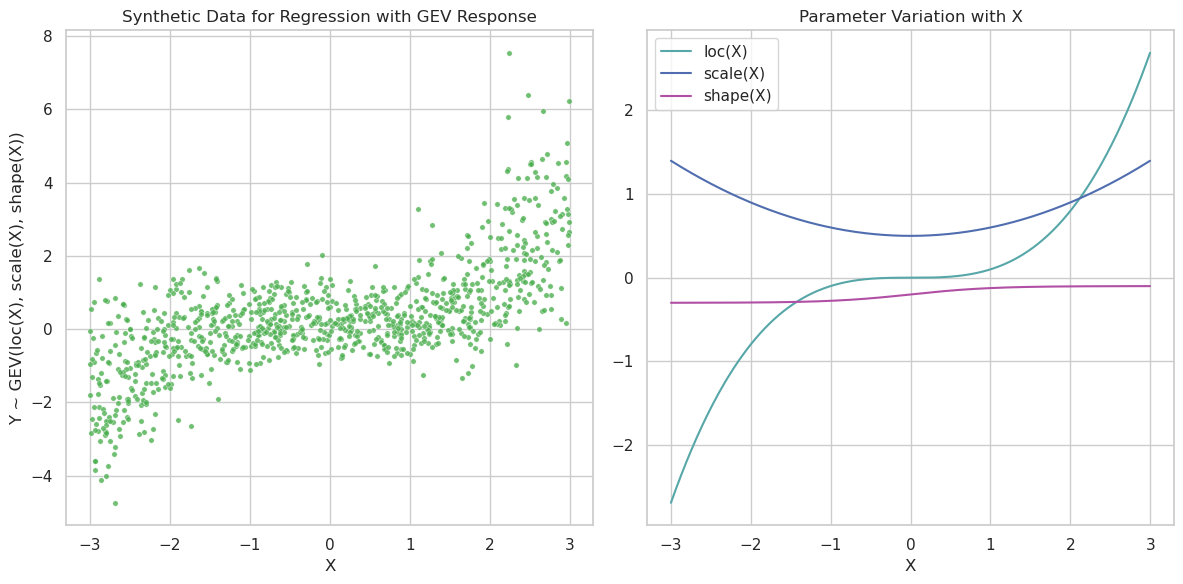

In [17]:
# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GEV_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
xs_sorted   = jnp.sort(X_GEV_SYN)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    return 0.1 * x**3

def scale_fn(x):
    return 0.1 * x**2 + 0.5

def shape_fn(x):
    return 0.1 * jnp.tanh(x) - 0.2

loc_vals   = loc_fn(X_GEV_SYN)
scale_vals = scale_fn(X_GEV_SYN)
shape_vals = shape_fn(X_GEV_SYN)

# ------------------------------------------------
# 3) Constructs a *batch* of GEVs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gev_dists = tfd.GeneralizedExtremeValue(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GEV_SYN_tf = gev_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GEV_SYN_data = jnp.array(Y_GEV_SYN_tf)


plot_gev_gpd_syn_data(
    X_GEV_SYN, 
    Y_GEV_SYN_data,
    regression_palette, 
    line_colors, 
    loc_fn,
    scale_fn,
    shape_fn,
    "X",
    "Y ~ GEV(loc(X), scale(X), shape(X))",
    "Synthetic Data for Regression with GEV Response",
    "X",
    "Parameter Variation with X",
    "loc(X)",
    "scale(X)",
    "shape(X)",
    "gev_syn_data_plot",
    gev_fits_dir,
)


### Simple Linear Predictors

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/linear_fit_loss_plot_window_50.svg


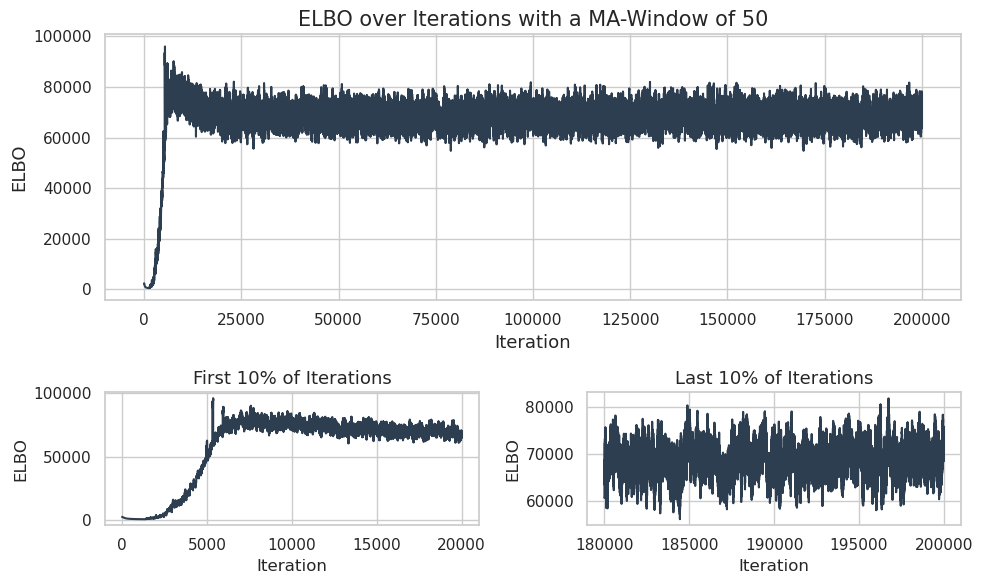

In [8]:
X_GEV_SYN_DesignMatrix = DataPreperator(
    "DesignMatrix",
    X_GEV_SYN,
    "identity",
    intercept=True,
    standardize=True,
)()
ncols = X_GEV_SYN_DesignMatrix.matrix.shape[1]

β_loc_GEV = Normal("betas_loc", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
β_scale_GEV = Normal("betas_scale", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
β_shape_GEV = Normal("betas_shape", jnp.zeros(ncols), jnp.ones(ncols)*100.0, ncols)
Y_GEV_SYN = CustomGEV(
    "y",
    X_GEV_SYN_DesignMatrix @ β_loc_GEV,
    X_GEV_SYN_DesignMatrix @ β_scale_GEV,
    X_GEV_SYN_DesignMatrix @ β_shape_GEV,
    responses=Y_GEV_SYN_data,
)
results_GEV_SYN_SLP = Y_GEV_SYN.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=50000,
    mb_size=256,
    lr=0.0001,
    max_norm=5.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
    scheduler_type="constant",
    # warmup_fraction=0.10,
    # init_value=0.000001,
    # alpha=0.000001
)

with open(gev_fits_dir + "/results_GEV_SYN_SLP.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_SLP, f)

plot_elbo(
    results_GEV_SYN_SLP["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_SLP["losses"],
    loss_color,
    0.1,
    gev_fits_dir,
    "linear_fit_loss_plot",
    window=50
)

/tmp/ipykernel_96537/834996069.py:25: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_slp_plot.svg


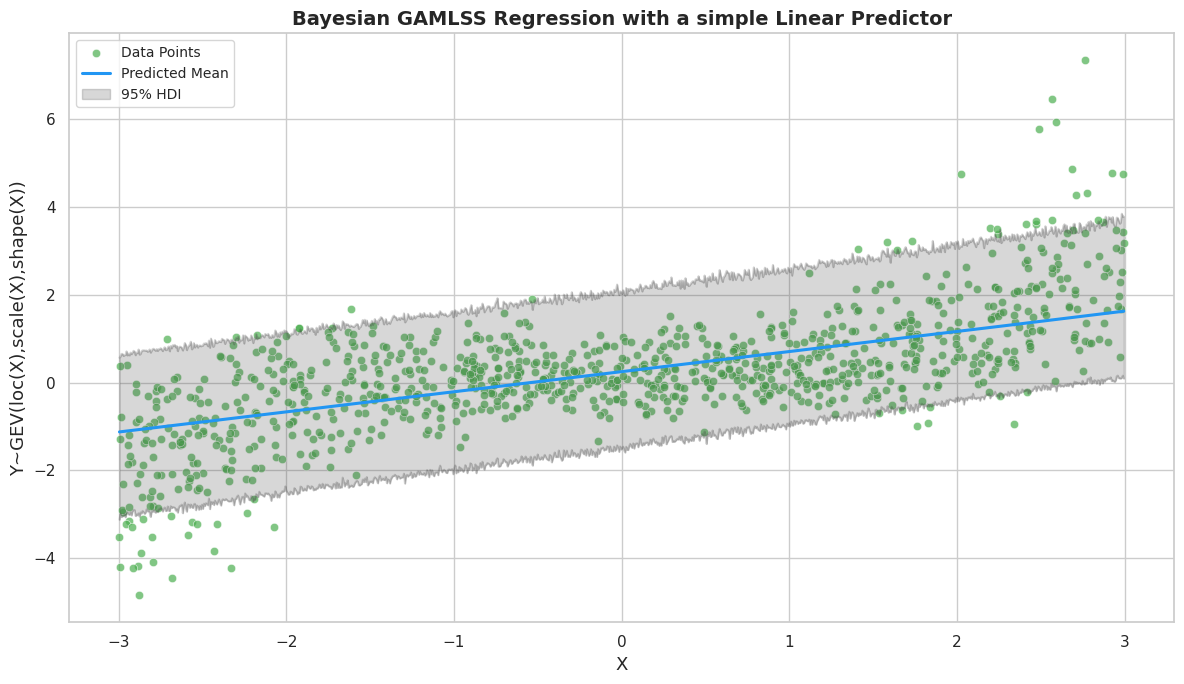

In [9]:
# Response is GPD GAMLSS Distributed Case
β_loc = results_GEV_SYN_SLP["transformed_loc_vi_parameters"]["betas_loc"]
β_scale = results_GEV_SYN_SLP["transformed_loc_vi_parameters"]["betas_scale"]
β_shape = results_GEV_SYN_SLP["transformed_loc_vi_parameters"]["betas_shape"]

X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "identity",
    intercept=True,
    standardize=True,
)()
linear_predictor_loc = X_line_design.matrix @ β_loc
linear_predictor_scale = TransformationFunctions.softplus(
    X_line_design.matrix @ β_scale
)
linear_predictor_shape = X_line_design.matrix @ β_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with a simple Linear Predictor',
    save_path=gev_fits_dir, 
    file_name="regression_slp_plot.svg"
)

### PSplines

#### 10 Knots

##### Model

In [22]:
X_GEV_SYM_PSpline_DesignMatrix = DataPreperator(
    "xDesign",
    X_GEV_SYN,
    "pspline",
    intercept=False,
    standardize=True,
    degree=3,
    num_knots=10,
)()
K = X_GEV_SYM_PSpline_DesignMatrix.K

β0_loc_GEV_PSpline = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_loc_GEV_PSpline = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
γ_loc_GEV_PSpline = DegenerateNormal("gammas_loc", K, λ_loc_GEV_PSpline)
β0_scale_GEV_PSpline = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_scale_GEV_PSpline = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
γ_scale_GEV_PSpline = DegenerateNormal("gammas_scale", K, λ_scale_GEV_PSpline)
β0_shape_GEV_PSpline = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_shape_GEV_PSpline = HalfCauchy("lambda_shape", jnp.array([0.1]), 1)
γ_shape_GEV_PSpline = DegenerateNormal("gammas_shape", K, λ_shape_GEV_PSpline)

Y_GEV_SYN_PSpline = CustomGEV(
    "y",
    β0_loc_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix @ γ_loc_GEV_PSpline,
    β0_scale_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix @ γ_scale_GEV_PSpline,
    β0_shape_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix @ γ_shape_GEV_PSpline,
    responses=Y_GEV_SYN_data,
)

##### Mean Field Gaussian VI Dist

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/PSpline_MF_10_knoloss_plot_window_50.svg


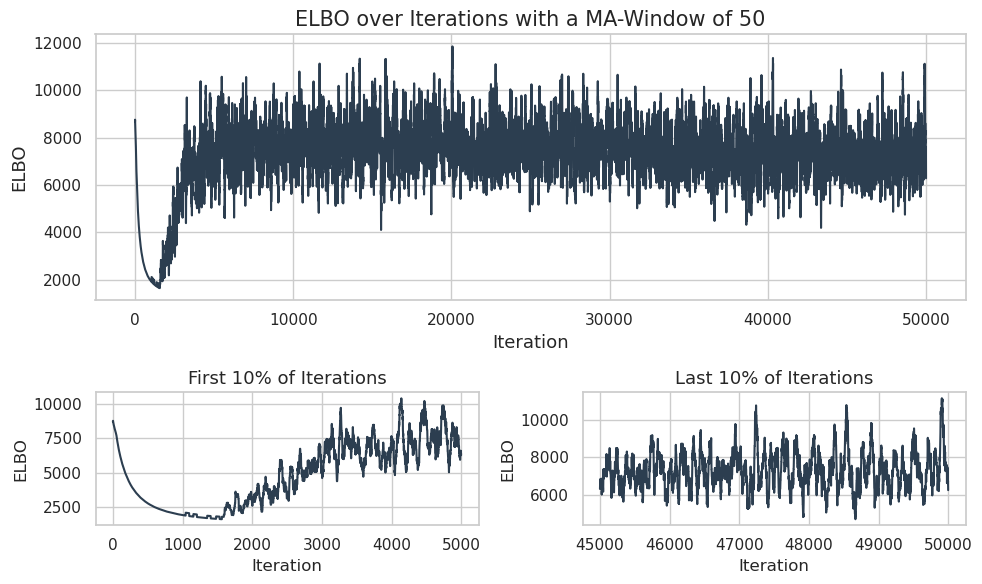

In [23]:
results_GEV_SYN_PSpline_MF = Y_GEV_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=MeanFieldNormal,
    vi_sample_size=64,
    epochs=50000,
    mb_size=None,
    lr=0.0001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(0),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.05,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gev_fits_dir + "/results_GEV_SYN_PSpline_MF.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_PSpline_MF, f)

plot_elbo(
    results_GEV_SYN_PSpline_MF["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_PSpline_MF["losses"],
    loss_color,
    0.1,
    gev_fits_dir,
    "PSpline_MF_10_knoloss_plot",
    window=50
)

/tmp/ipykernel_96537/3654861825.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_Psplines_MF_plot.svg


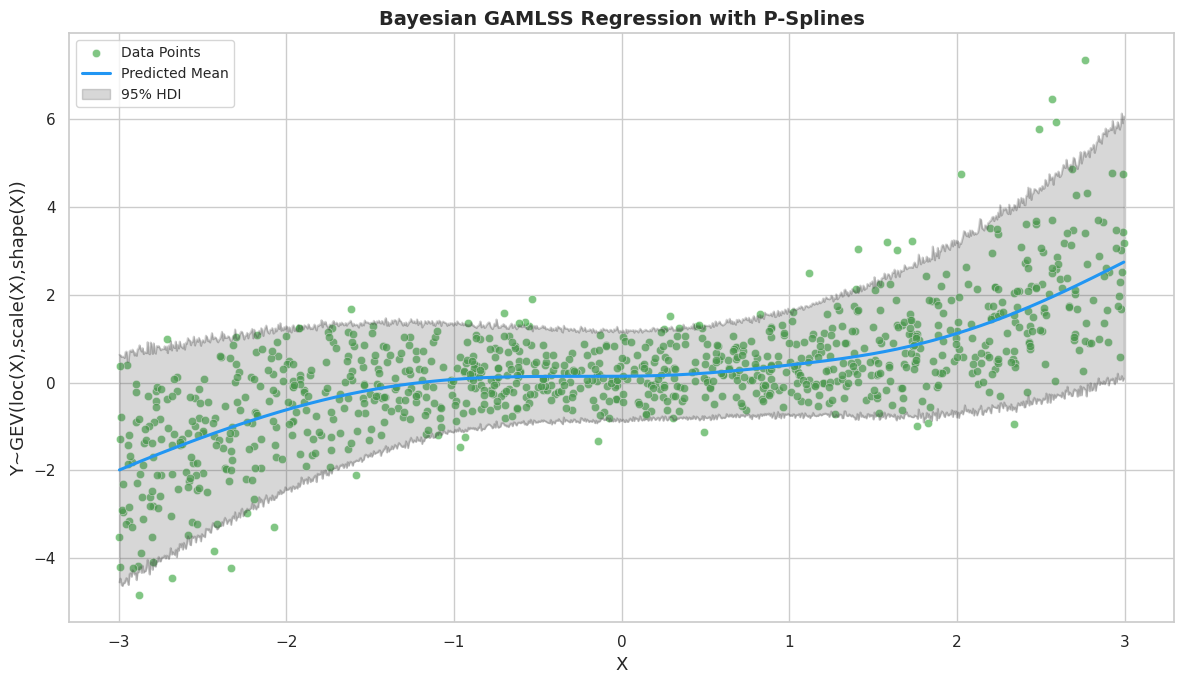

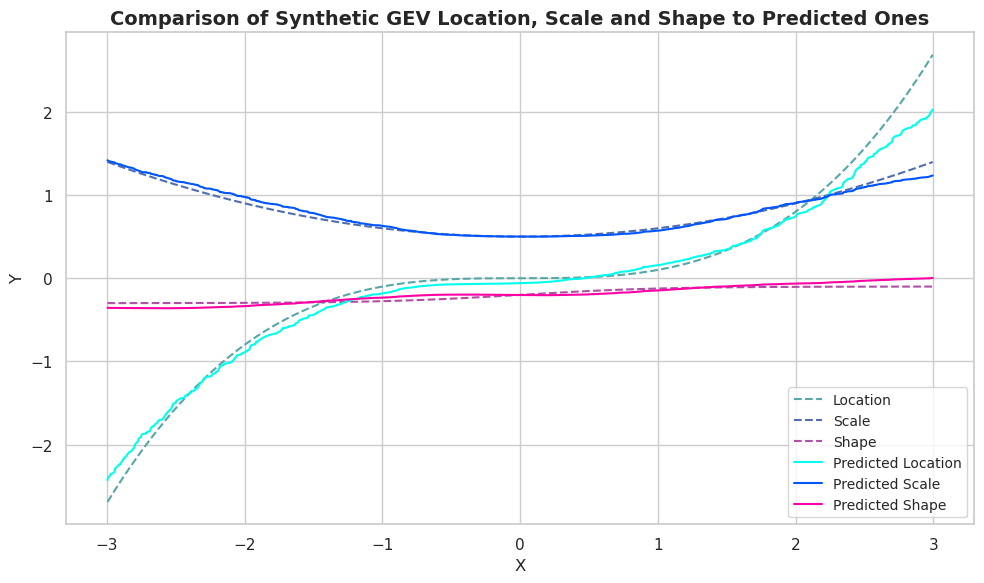

In [24]:
β0_loc = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GEV_SYN_PSpline_MF["transformed_loc_vi_parameters"]["gammas_shape"]


X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with P-Splines',
    save_path=gev_fits_dir, 
    file_name="regression_Psplines_MF_plot.svg"
)

plot_loc_scale_shape_comparison(
    X_GEV_SYN,
    line_loc=loc_fn,
    line_scale=scale_fn,
    line_shape=shape_fn,
    line_loc_pred=linear_predictor_loc,
    line_scale_pred=linear_predictor_scale,
    line_shape_pred=linear_predictor_shape,
    non_pred_palette=line_colors,
    pred_palette=pred_line_colors,
    title="Comparison of Synthetic GEV Location, Scale and Shape to Predicted Ones",
    xlabel="X",
    ylabel="Y",
)

##### Full Covariance Gaussian VI Dist

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/PSpline_FC_10_knots_loss_plot_window_50.svg


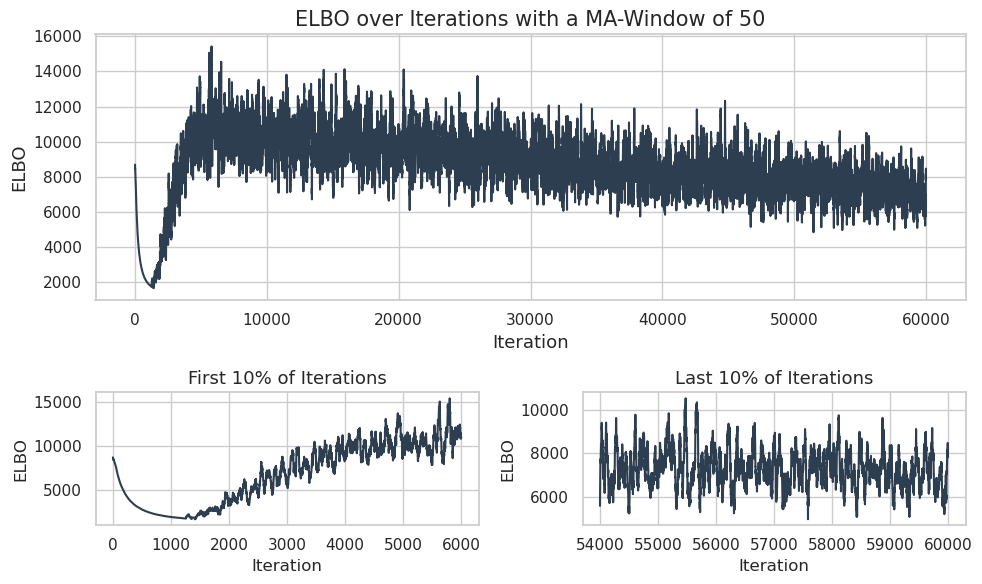

In [25]:
results_GEV_SYN_PSpline_FC = Y_GEV_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=60000,
    mb_size=None,
    lr=0.0001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(1),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.1,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gev_fits_dir + "/results_GEV_SYN_PSpline_FC.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_PSpline_FC, f)

plot_elbo(
    results_GEV_SYN_PSpline_FC["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_PSpline_FC["losses"],
    loss_color,
    0.1,
    gev_fits_dir,
    "PSpline_FC_10_knots_loss_plot",
    window=50
)

/tmp/ipykernel_96537/4287698622.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_Psplines_FC_10knots_plot.svg


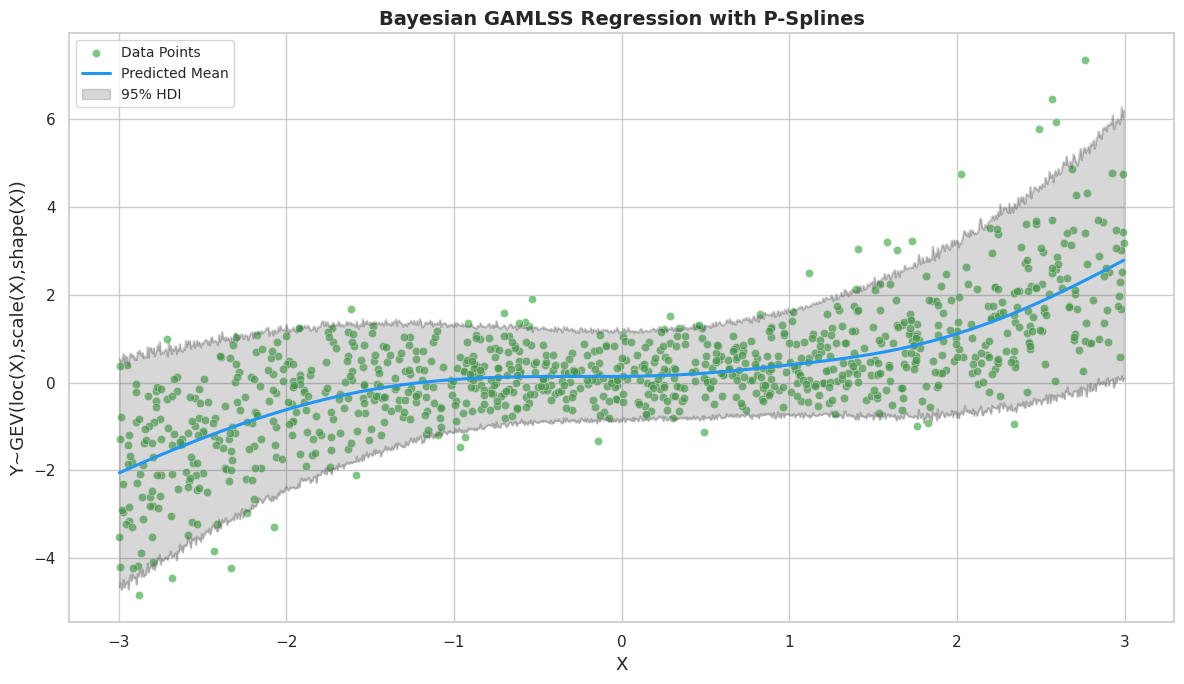

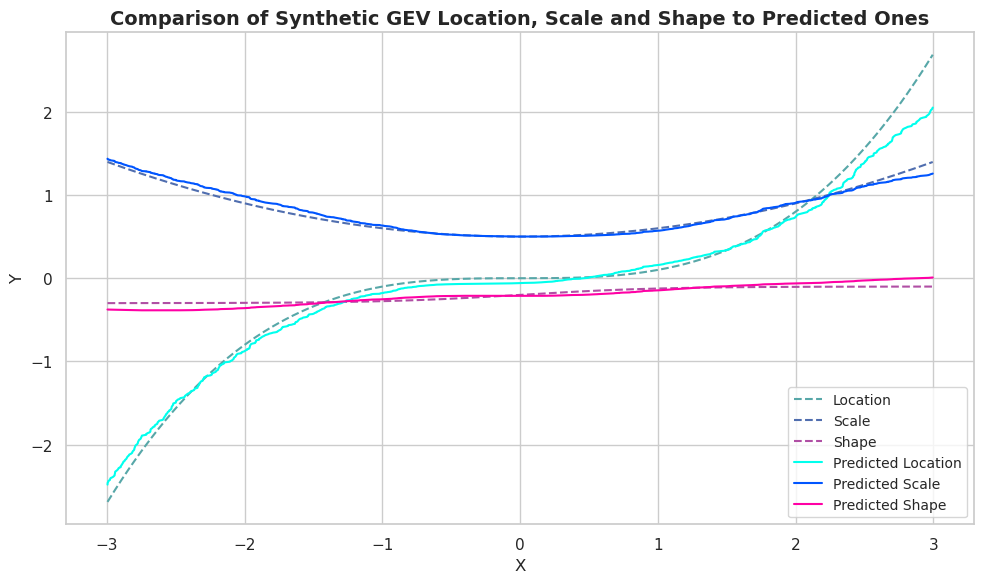

In [26]:
β0_loc = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_shape"]


X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with P-Splines',
    save_path=gev_fits_dir, 
    file_name="regression_Psplines_FC_10knots_plot.svg"
)

plot_loc_scale_shape_comparison(
    X_GEV_SYN,
    line_loc=loc_fn,
    line_scale=scale_fn,
    line_shape=shape_fn,
    line_loc_pred=linear_predictor_loc,
    line_scale_pred=linear_predictor_scale,
    line_shape_pred=linear_predictor_shape,
    non_pred_palette=line_colors,
    pred_palette=pred_line_colors,
    title="Comparison of Synthetic GEV Location, Scale and Shape to Predicted Ones",
    xlabel="X",
    ylabel="Y",
)

#### 20 Knots

##### Model

In [18]:
X_GEV_SYM_PSpline_DesignMatrix20Knots = DataPreperator(
    "xDesign",
    X_GEV_SYN,
    "pspline",
    intercept=False,
    standardize=True,
    degree=3,
    num_knots=20,
)()
K = X_GEV_SYM_PSpline_DesignMatrix20Knots.K

β0_loc_GEV_PSpline = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_loc_GEV_PSpline = HalfCauchy("lambda_loc", jnp.array([0.01]), 1)
γ_loc_GEV_PSpline = DegenerateNormal("gammas_loc", K, λ_loc_GEV_PSpline)
β0_scale_GEV_PSpline = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_scale_GEV_PSpline = HalfCauchy("lambda_scale", jnp.array([0.01]), 1)
γ_scale_GEV_PSpline = DegenerateNormal("gammas_scale", K, λ_scale_GEV_PSpline)
β0_shape_GEV_PSpline = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_shape_GEV_PSpline = HalfCauchy("lambda_shape", jnp.array([0.01]), 1)
γ_shape_GEV_PSpline = DegenerateNormal("gammas_shape", K, λ_shape_GEV_PSpline)

Y_GEV_SYN_PSpline = CustomGEV(
    "y",
    β0_loc_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix20Knots @ γ_loc_GEV_PSpline,
    β0_scale_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix20Knots @ γ_scale_GEV_PSpline,
    β0_shape_GEV_PSpline + X_GEV_SYM_PSpline_DesignMatrix20Knots @ γ_shape_GEV_PSpline,
    responses=Y_GEV_SYN_data,
)

##### Full Covariance Gaussian VI Dist

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/PSpline_FC_10_knots_loss_plot_window_50.svg


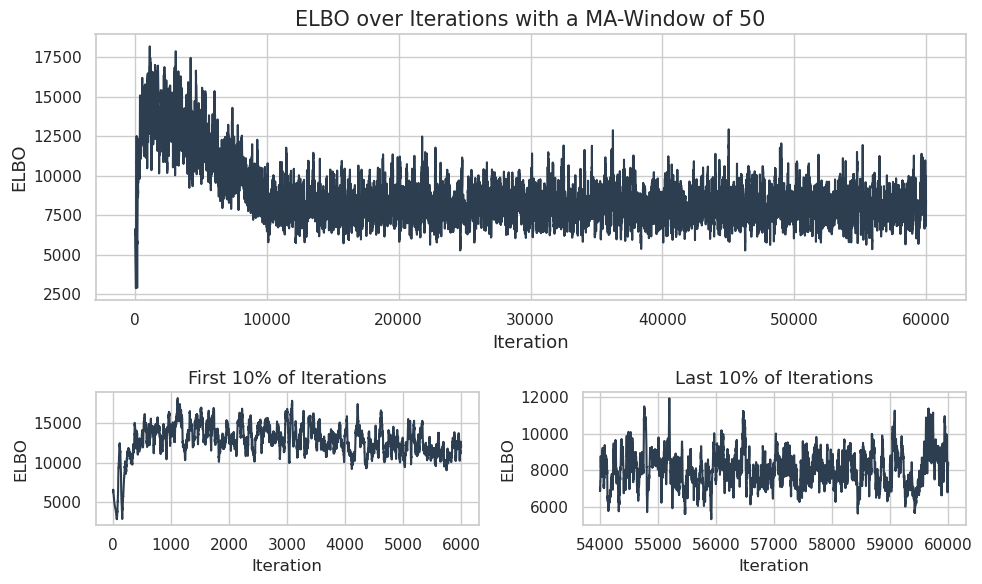

In [19]:
results_GEV_SYN_PSpline_FC = Y_GEV_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=60000,
    mb_size=None,
    lr=0.001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(1),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.1,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gev_fits_dir + "/results_GEV_SYN_PSpline_FC.pkl", "wb") as f:
    pkl.dump(results_GEV_SYN_PSpline_FC, f)

plot_elbo(
    results_GEV_SYN_PSpline_FC["svi_metadata"]["num_iterations"], 
    results_GEV_SYN_PSpline_FC["losses"],
    loss_color,
    0.1,
    gev_fits_dir,
    "PSpline_FC_10_knots_loss_plot",
    window=50
)

/tmp/ipykernel_135405/966565359.py:30: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gev_fits/regression_Psplines_FC_10knots_plot.svg


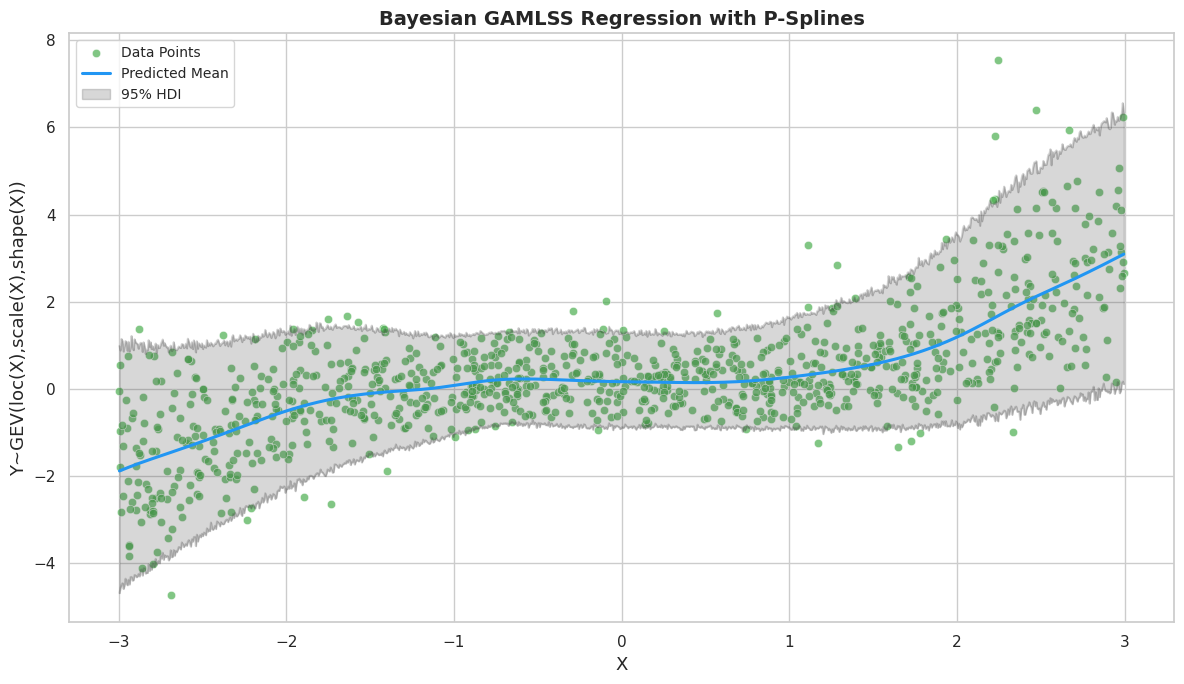

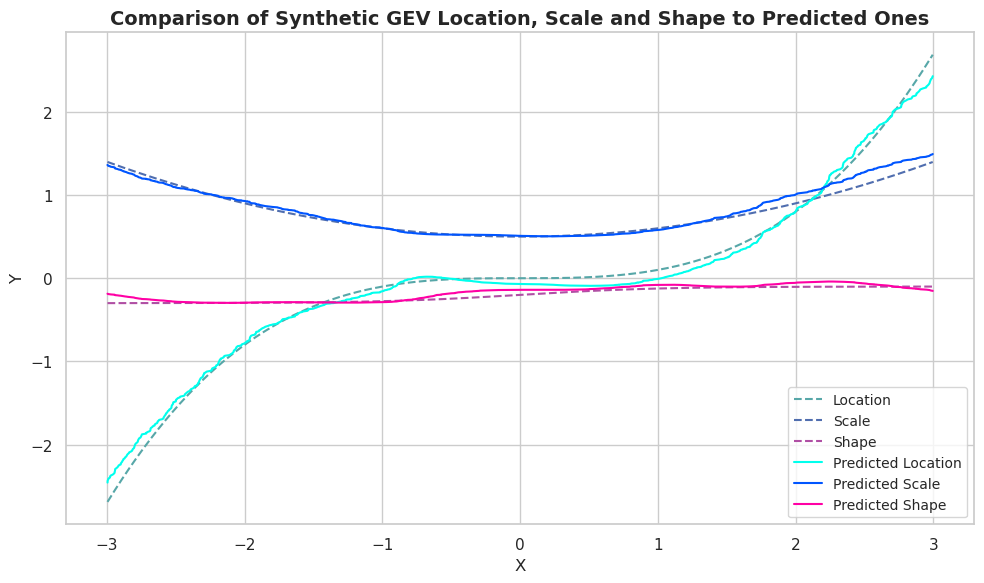

In [21]:
β0_loc = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GEV_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_shape"]


X_min, X_max = X_GEV_SYN.min(), X_GEV_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=20
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape

GEV = tfd.GeneralizedExtremeValue(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GEV.sample((5000,),PRNGKey(0))
mean_line = GEV.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GEV_SYN,
    Y_GEV_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GEV(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with P-Splines',
    save_path=gev_fits_dir, 
    file_name="regression_Psplines_FC_10knots_plot.svg"
)

plot_loc_scale_shape_comparison(
    X_GEV_SYN,
    line_loc=loc_fn,
    line_scale=scale_fn,
    line_shape=shape_fn,
    line_loc_pred=linear_predictor_loc,
    line_scale_pred=linear_predictor_scale,
    line_shape_pred=linear_predictor_shape,
    non_pred_palette=line_colors,
    pred_palette=pred_line_colors,
    title="Comparison of Synthetic GEV Location, Scale and Shape to Predicted Ones",
    xlabel="X",
    ylabel="Y",
)

## VIGAMLSS with GPD Response and PSplines

### Synthetic Data Creation

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gpd_fits/gpd_syn_data_plot.svg


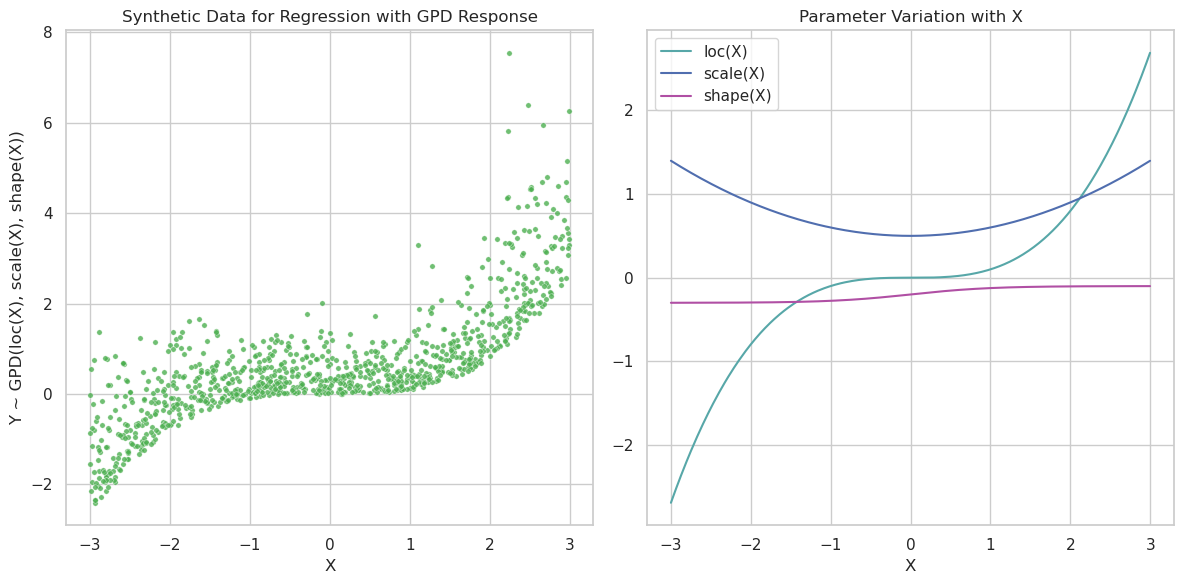

In [5]:
# ------------------------------------------------
# 1) Generate covariate X
# ------------------------------------------------
key = jax.random.PRNGKey(42)
n_samples = 1000
key_x, key_y = jax.random.split(key)
X_GPD_SYN = jax.random.uniform(key_x, shape=(n_samples,), minval=-3.0, maxval=3.0)
xs_sorted   = jnp.sort(X_GPD_SYN)

# ------------------------------------------------
# 2) Define parametric functions for loc(x), scale(x), shape(x)
# ------------------------------------------------

def loc_fn(x):
    return 0.1 * x**3

def scale_fn(x):
    return 0.1 * x**2 + 0.5

def shape_fn(x):
    return 0.1 * jnp.tanh(x) - 0.2

loc_vals   = loc_fn(X_GPD_SYN)
scale_vals = scale_fn(X_GPD_SYN)
shape_vals = shape_fn(X_GPD_SYN)

# ------------------------------------------------
# 3) Constructs a *batch* of GPDs, one per (x_i).
#    TFP automatically enforces domain logic for each sample.
# ------------------------------------------------
gpd_dists = tfd.GeneralizedPareto(
    loc          = loc_vals,     # shape=(n_samples,)
    scale        = scale_vals,   # shape=(n_samples,)
    concentration= shape_vals    # shape=(n_samples,)
)

# ------------------------------------------------
# 4) Sample Y given X
# ------------------------------------------------
Y_GPD_SYN_tf = gpd_dists.sample(seed=key_y)  # shape=(n_samples,)
Y_GPD_SYN_data = jnp.array(Y_GPD_SYN_tf)


plot_gev_gpd_syn_data(
    X_GPD_SYN, 
    Y_GPD_SYN_data,
    regression_palette, 
    line_colors, 
    loc_fn,
    scale_fn,
    shape_fn,
    "X",
    "Y ~ GPD(loc(X), scale(X), shape(X))",
    "Synthetic Data for Regression with GPD Response",
    "X",
    "Parameter Variation with X",
    "loc(X)",
    "scale(X)",
    "shape(X)",
    "gpd_syn_data_plot",
    gpd_fits_dir,
)


### 10 Knots

#### Model

In [17]:
X_GPD_SYM_PSpline_DesignMatrix = DataPreperator(
    "xDesign",
    X_GPD_SYN,
    "pspline",
    intercept=False,
    standardize=True,
    degree=3,
    num_knots=10,
)()
K = X_GPD_SYM_PSpline_DesignMatrix.K

β0_loc_GPD_PSpline = Normal("beta0_loc", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_loc_GPD_PSpline = HalfCauchy("lambda_loc", jnp.array([0.1]), 1)
γ_loc_GPD_PSpline = DegenerateNormal("gammas_loc", K, λ_loc_GPD_PSpline)
β0_scale_GPD_PSpline = Normal("beta0_scale", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_scale_GPD_PSpline = HalfCauchy("lambda_scale", jnp.array([0.1]), 1)
γ_scale_GPD_PSpline = DegenerateNormal("gammas_scale", K, λ_scale_GPD_PSpline)
β0_shape_GPD_PSpline = Normal("beta0_shape", jnp.array([0.0]), jnp.array([10.0]), 1)
λ_shape_GPD_PSpline = HalfCauchy("lambda_shape", jnp.array([0.01]), 1)
γ_shape_GPD_PSpline = DegenerateNormal("gammas_shape", K, λ_shape_GPD_PSpline)

Y_GPD_SYN_PSpline = CustomGPD(
    "y",
    β0_loc_GPD_PSpline + X_GPD_SYM_PSpline_DesignMatrix @ γ_loc_GPD_PSpline,
    β0_scale_GPD_PSpline + X_GPD_SYM_PSpline_DesignMatrix @ γ_scale_GPD_PSpline,
    β0_shape_GPD_PSpline + X_GPD_SYM_PSpline_DesignMatrix @ γ_shape_GPD_PSpline,
    responses=Y_GPD_SYN_data,
)

#### Full Covariance Gaussian VI Dist

Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gpd_fits/linear_fit_loss_plot_window_50.svg


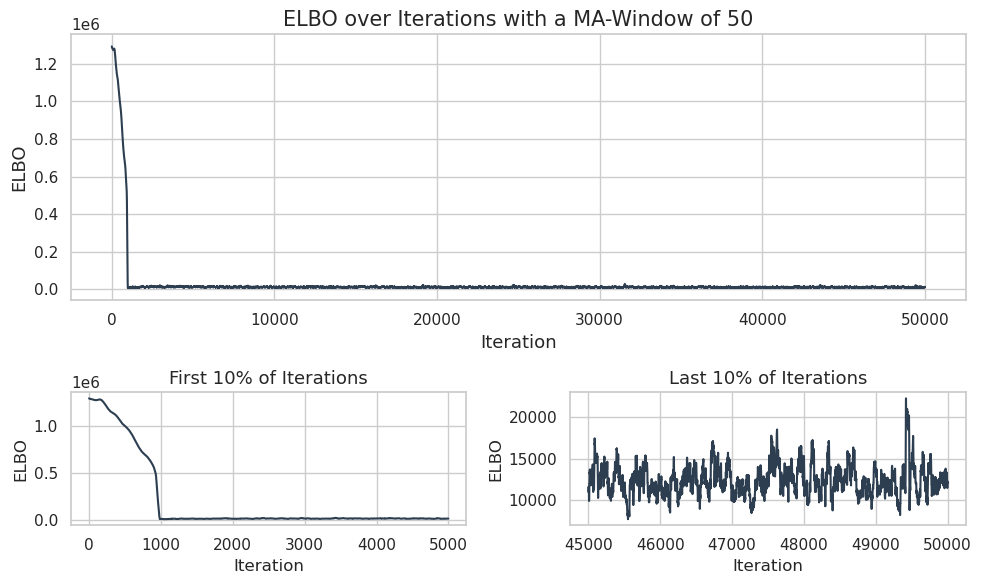

In [20]:
results_GPD_SYN_PSpline_FC = Y_GPD_SYN_PSpline.model.run_svi_optimization(
    optimizer=adam,
    vi_dist=FullCovarianceNormal,
    vi_sample_size=64,
    epochs=50000,
    mb_size=None,
    lr=0.001,
    max_norm=1.0,
    clip_min_max_enabled=True,
    zero_nans_enabled=True,
    prng_key=PRNGKey(1),
    scheduler_type="constant",#"warmup_cosine_decay",
    # warmup_fraction=0.1,
    # init_value=0.00001,
    # end_value=0.00001,
)

with open(gpd_fits_dir + "/results_GPD_SYN_SLP.pkl", "wb") as f:
    pkl.dump(results_GPD_SYN_PSpline_FC, f)

plot_elbo(
    results_GPD_SYN_PSpline_FC["svi_metadata"]["num_iterations"], 
    results_GPD_SYN_PSpline_FC["losses"],
    loss_color,
    0.1,
    gpd_fits_dir,
    "linear_fit_loss_plot",
    window=50
)

/tmp/ipykernel_176841/320142752.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)


Plot saved to /home/marcel/OneDrive/Uni/UniGoett/6_Masterarbeit/master-s-thesis/data/gpd_fits/regression_slp_plot.svg


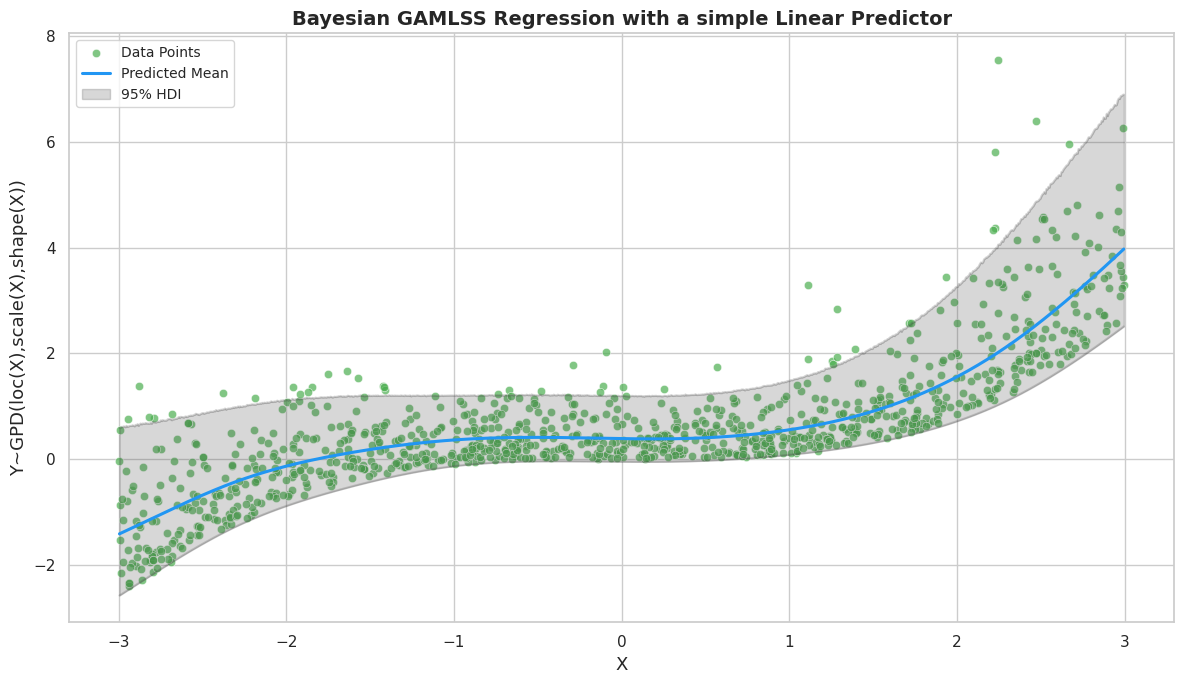

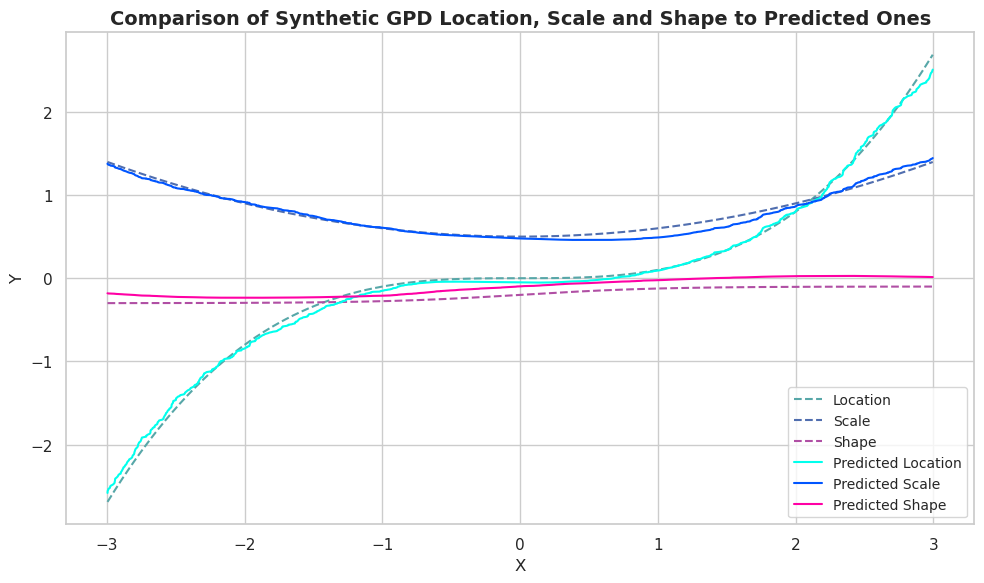

In [21]:
# Response is GPD GAMLSS Distributed Case
β0_loc = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_loc"]
β0_scale = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_scale"]
β0_shape = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["beta0_shape"]
γ_loc = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_loc"]
γ_scale = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_scale"]
γ_shape = results_GPD_SYN_PSpline_FC["transformed_loc_vi_parameters"]["gammas_shape"]

X_min, X_max = X_GPD_SYN.min(), X_GPD_SYN.max()
X_line = np.linspace(X_min, X_max, 1000)
X_line_design = DataPreperator(
    "xDesign",
    X_line,
    "pspline",
    intercept=False,
    standardize=False,
    degree=3,
    num_knots=10
)()
linear_predictor_loc = β0_loc + X_line_design.matrix@γ_loc
linear_predictor_scale = TransformationFunctions.softplus(
    β0_scale + X_line_design.matrix@γ_scale
)
linear_predictor_shape = β0_shape + X_line_design.matrix@γ_shape
GPD = tfd.GeneralizedPareto(linear_predictor_loc, linear_predictor_scale, linear_predictor_shape)
samples = GPD.sample((100000,),PRNGKey(0))
mean_line = GPD.mean()
samples_np = np.array(samples)
hdi_bounds = az.hdi(samples_np, hdi_prob=0.95)
hdi_lower = hdi_bounds[:,0]
hdi_upper = hdi_bounds[:,1]

plot_regression_with_interval(
    X_GPD_SYN,
    Y_GPD_SYN_data,
    X_line,
    mean_line,
    hdi_lower,
    hdi_upper,
    0.21,
    regression_palette,
    scatter_label='Data Points',
    regression_label='Predicted Mean',
    interval_label='95% HDI',
    xlabel='X',
    ylabel='Y~GPD(loc(X),scale(X),shape(X))',
    title='Bayesian GAMLSS Regression with a simple Linear Predictor',
    save_path=gpd_fits_dir, 
    file_name="regression_slp_plot.svg"
)

plot_loc_scale_shape_comparison(
    X_GPD_SYN,
    line_loc=loc_fn,
    line_scale=scale_fn,
    line_shape=shape_fn,
    line_loc_pred=linear_predictor_loc,
    line_scale_pred=linear_predictor_scale,
    line_shape_pred=linear_predictor_shape,
    non_pred_palette=line_colors,
    pred_palette=pred_line_colors,
    title="Comparison of Synthetic GPD Location, Scale and Shape to Predicted Ones",
    xlabel="X",
    ylabel="Y",
)